<a href="https://colab.research.google.com/github/RichardHarwood/3D_Unet_Plant_Roots/blob/main/3D_Unet_general_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget
!pip install open3d
!pip install vedo
#!pip install stackview ipycanvas==0.11
import os
!git clone https://github.com/wolny/pytorch-3dunet.git
%cd pytorch-3dunet
!python setup.py install

fatal: destination path 'pytorch-3dunet' already exists and is not an empty directory.
/content/pytorch-3dunet
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_instal

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#need to set appropriate  home folder
import os.path
from os import path
if path.exists('/content/drive/MyDrive/3D_UNET_general_eg/') == False:
  os.mkdir('/content/drive/MyDrive/3D_UNET_general_eg/')
home_folder = "/content/drive/MyDrive/3D_UNET_general_eg/"

In [5]:
#Create Config Folder
if path.exists(home_folder+'config_files') == False:
  os.mkdir(home_folder+'config_files')
config_folder = home_folder+'config_files/'

In [6]:
#Create Checkpoint Folder
if path.exists(home_folder+'checkpoint_dir') == False:
  os.mkdir(home_folder+'checkpoint_dir')
checkpoint_dir = home_folder+'checkpoint_dir/'

In [7]:
#Create Folder to store images we want to segment
if path.exists(home_folder+'segment_this_folder') == False:
  os.mkdir(home_folder+'segment_this_folder')
imgs_to_seg_dir = home_folder+'segment_this_folder/'

**Download data that the model has never seen before**


In [18]:
import wget
if os.path.isfile(imgs_to_seg_dir+'2-3_enhanced.tif.h5'):
  print("image already download")
else:
  wget.download("https://zenodo.org/records/13958667/files/"+"2-3_enhanced.tif.h5"+"?download=1", out=imgs_to_seg_dir+'2-3_enhanced.tif.h5')

image already download


**Download the model trained from Harwood et al hand segmentations**


In [19]:
if os.path.isfile(checkpoint_dir+'3D_Unet_Root_Model.pytorch'):
  print("model already download")
wget.download("https://zenodo.org/records/13958667/files/"+"3D_Unet_Root_Model.pytorch"+"?download=1", out=checkpoint_dir+'3D_Unet_Root_Model.pytorch')

model already download


'/content/drive/MyDrive/3D_UNET_general_eg/checkpoint_dir/3D_Unet_Root_Model (1).pytorch'

**Look at the data we want to segment**

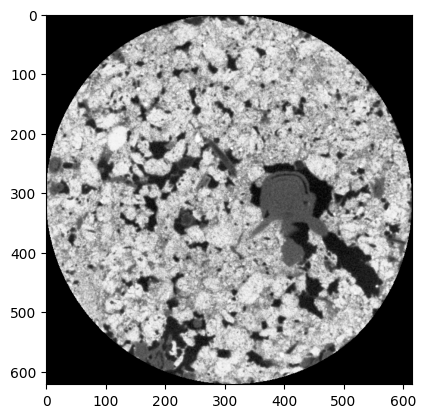

In [10]:
import h5py
import numpy as np
hf=h5py.File(imgs_to_seg_dir+'2-3_enhanced.tif.h5')
hf.keys()
raw_IMGs= hf['raw']
image_raw=raw_IMGs[:]

import matplotlib.pyplot as plt
plt.imshow(image_raw[3], cmap="gray");

**Create a config file to segment the downloaded image with the downloaded model**

In [11]:
model_name = "UNet3D"
in_channels = 1
out_channels= 1
layer_order = "gcr"
f_maps = [32,
          64,
          128,
          256]
num_groups = 8
final_sigmoid = True
is_segmentation = True
batch_size= 1  #important for gpu memory
num_workers= 2
raw_internal_path= "raw"
label_internal_path= "label"
weight_internal_path= None
######################
slice_builder_name= "SliceBuilder"
slice_builder_name_predict = "SliceBuilder"
patch_shape= [40, 170, 170]  #Change depending on GPU memory
stride_shape= [20, 40, 40]   #Change depending on GPU memory
halo_shape= [16, 32, 32]
threshold = 0.01
slack_acceptance = 0.01
name_transformer= "Standardize"
name_transformer_label= "BlobsToMask"
append_label= False
boundary= False
ToTensor_name = "ToTensor"
expand_dims_false= False
expand_dims_true= True
#####################
predictor_name='StandardPredictor'
#################################
file_paths_test= imgs_to_seg_dir
#############################
model_path=checkpoint_dir+'3D_Unet_Root_Model.pytorch'

In [12]:
import yaml
test_config_yaml ={
    "model_path": model_path,
    "model": {
        "name": model_name,
        "in_channels": in_channels,
        "out_channels": out_channels,
        "layer_order": layer_order,
        "f_maps": f_maps,
        "num_groups": num_groups,
        "final_sigmoid": final_sigmoid,
        "is_segmentation": is_segmentation
    },
    "predictor": {
        "name": predictor_name
    },
    "loaders": {
        "batch_size": batch_size,
        "raw_internal_path": raw_internal_path,
        "num_workers": num_workers,
        "test": {
            "file_paths": [
                file_paths_test
            ],
            "slice_builder": {
                "name": slice_builder_name_predict,
                "patch_shape": patch_shape,
                "stride_shape": patch_shape,
                "halo_shape": halo_shape
            },
            "transformer": {
                "raw": [
                    {
                        "name": name_transformer
                    },
                    {
                        "name": ToTensor_name,
                        "expand_dims": expand_dims_true
                    }
                ]
            }
        }
    }
}

with open(config_folder+'predict.yaml', 'w') as yaml_file:
    yaml.dump(test_config_yaml, yaml_file, default_flow_style=False, sort_keys=False)


**Start Predicting**

Currently this assumes we are using the model we trained above, if using a different model define “model_path” acconringly and if need be tweak any details of the test_config.yaml

The test_config.yaml will run the 3D-Unet model on every image in a folder, it will export out an image of confidence values for each voxel (0, the model thinks the voxel isn’t a root, higher values indicate more confidence the voxel is a root)

Running the sgemenation is the same as training the model

`!predict3dunet --config /content/drive/MyDrive/3D_UNET/config_files/predict.yaml`

The segmented files will have the same name but .prediction gets added to the end of the file name.

In [13]:
!predict3dunet --config /content/drive/MyDrive/3D_UNET_general_eg/config_files/predict.yaml

2024-11-15 04:00:53,758 [MainThread] INFO UNet3DPredict - Loading model from /content/drive/MyDrive/3D_UNET_general_eg/checkpoint_dir/3D_Unet_Root_Model.pytorch...
/usr/local/lib/python3.10/dist-packages/pytorch3dunet-1.8.7-py3.10.egg/pytorch3dunet/unet3d/utils.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use cas

In [21]:
import glob
import numpy as np
raw_data_path= file_paths_test
raw_file_names = [os.path.basename(x) for x in glob.glob(imgs_to_seg_dir+"*.h5")]
raw_file_names = [e for e in raw_file_names if "predictions" in e ]
#################################
if path.exists(home_folder+'processed/') == False:
  os.mkdir(home_folder+'processed/')

file_paths_processed= home_folder+'processed/'
#########################
raw_file_names


['2-3_enhanced.tif_predictions.h5']

In [22]:
UNIQUE_ID =np.unique(raw_file_names)
len(UNIQUE_ID)

1

In [23]:
import h5py
import cv2
import skimage
from skimage.filters import threshold_otsu, threshold_yen
from skimage.measure import label
from skimage.morphology import remove_small_objects
from vedo import *
for i in UNIQUE_ID:
    print(i)
    hf=h5py.File(raw_data_path+i)
    hf.keys()
    dataset_IMGs= hf['predictions']
    image=dataset_IMGs[:]
    image=image[0,:,:,:]
    #image=zoom(image, (scale_factor,scale_factor, scale_factor), order=1)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    #thresh = threshold_yen(image)-45
    thresh=1
    print (thresh)
    binary = image > thresh
    #the below steps might be useful is your 3D output is not so great
    #binary=zoom(binary, (scale_factor,scale_factor, scale_factor), order=0)
    #root_sml=label(binary)
    #min_size_coef=1500 #trial and error really
    #root_sml_obj = remove_small_objects(root_sml, min_size=min_size_coef, connectivity=2)
    #root_sml_obj = (root_sml_obj != 0).astype(bool)

    root_VOL = Volume(binary, spacing=((1),(1),(1)))
    root_ISO = root_VOL.isosurface(1)
    root_ISO.write(file_paths_processed+i+"__root.stl")
    skimage.io.imsave(file_paths_processed+i+"_processed.tif", binary, check_contrast=False)

2-3_enhanced.tif_predictions.h5
1


<ipython-input-23-916287edd19e>:31: UserWarning: /content/drive/MyDrive/3D_UNET_general_eg/processed/2-3_enhanced.tif_predictions.h5_processed.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skimage.io.imsave(file_paths_processed+i+"_processed.tif", binary, check_contrast=False)


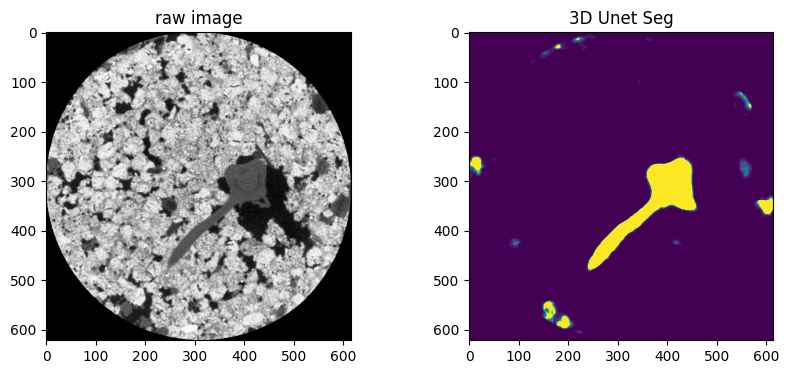

In [24]:
fig, ax = plt.subplots(1, 2, figsize=[10, 4]);
ax[0].imshow(image_raw[20], cmap="gray");
ax[0].set_title('raw image');

ax[1].imshow(image[20], vmin=0, vmax=15);
ax[1].set_title('3D Unet Seg');

In [25]:
!apt-get update
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,108 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,164 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,615 kB]
Get:13 http://archive.ubuntu.com

In [ ]:
# #Static rendering but PyVista crashed colab
# !apt-get update
# !apt-get install -qq xvfb libgl1-mesa-glx
# !pip install pyvista -qq
# import pyvista as pv
# model_to_test="2-3_enhanced.tif_predictions.h5__root.stl"
# root_stl=pv.read(file_paths_processed+model_to_test)
# root_stl.plot()

Below you can interact with the surface mesh

In [ ]:
import open3d as o3d
import plotly.graph_objects as go
model_to_test="2-3_enhanced.tif_predictions.h5__root.stl"
mesh = o3d.io.read_triangle_mesh(file_paths_processed+model_to_test)
if not mesh.has_vertex_normals(): mesh.compute_vertex_normals()
if not mesh.has_triangle_normals(): mesh.compute_triangle_normals()
triangles = np.asarray(mesh.triangles)
vertices = np.asarray(mesh.vertices)
colors = None

colors = (1.0, 0.0, 0.0)

fig = go.Figure(
    data=[
        go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50)
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()